In [2]:
import torch
import numpy as np
import pandas as pd
import math
import time
import os

import matplotlib.pyplot as plt

import torchvision
from torchvision.models.detection import (
    ssdlite320_mobilenet_v3_large,
    SSDLite320_MobileNet_V3_Large_Weights,
    ssd300_vgg16,
    SSD300_VGG16_Weights
)
from torchvision.transforms import v2
from torchvision.ops import box_iou, box_convert
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from pathlib import Path

import CarImageClass

from SSD_from_scratch import mySSD
from SSD_trainer import SSD_train, plot_losses, collate_detection, ConditionalIoUCrop, load_checkpoint, build_targets, build_optimizer_and_scheduler

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"C:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 120  |  mAP: 0.4835  |  Train loc loss: 0.1925  |  Train class loss: 0.5337  |  Test loc loss: 0.2246  |  Test class loss: 1.7527
Epoch: 121  |  mAP: 0.4725  |  Train loc loss: 0.1918  |  Train class loss: 0.5337  |  Test loc loss: 0.2302  |  Test class loss: 1.6593
Epoch: 122  |  mAP: 0.4799  |  Train loc loss: 0.1870  |  Train class loss: 0.5224  |  Test loc loss: 0.2247  |  Test class loss: 1.7894
Epoch: 123  |  mAP: 0.4792  |  Train loc loss: 0.1839  |  Train class loss: 0.5120  |  Test loc loss: 0.2251  |  Test class loss: 1.6360
Epoch: 124  |  mAP: 0.4785  |  Train loc loss: 0.1821  |  Train class loss: 0.5073  |  Test loc loss: 0.2163  |  Test class loss: 1.6969
Epoch: 125  |  mAP: 0.4831  |  Train loc loss: 0.1780  |  Train class loss: 0.5027  |  Test loc loss: 0.2155  |  Test class loss: 1.7264
Epoch: 126  |  mAP: 0.4871  |  Train loc loss: 0.1739  |  Train class loss: 0.4930  |  Test loc loss: 0.2137  |  Test class loss: 1.6749
Epoch: 127  |  mAP: 0.4956  |  Train loc 

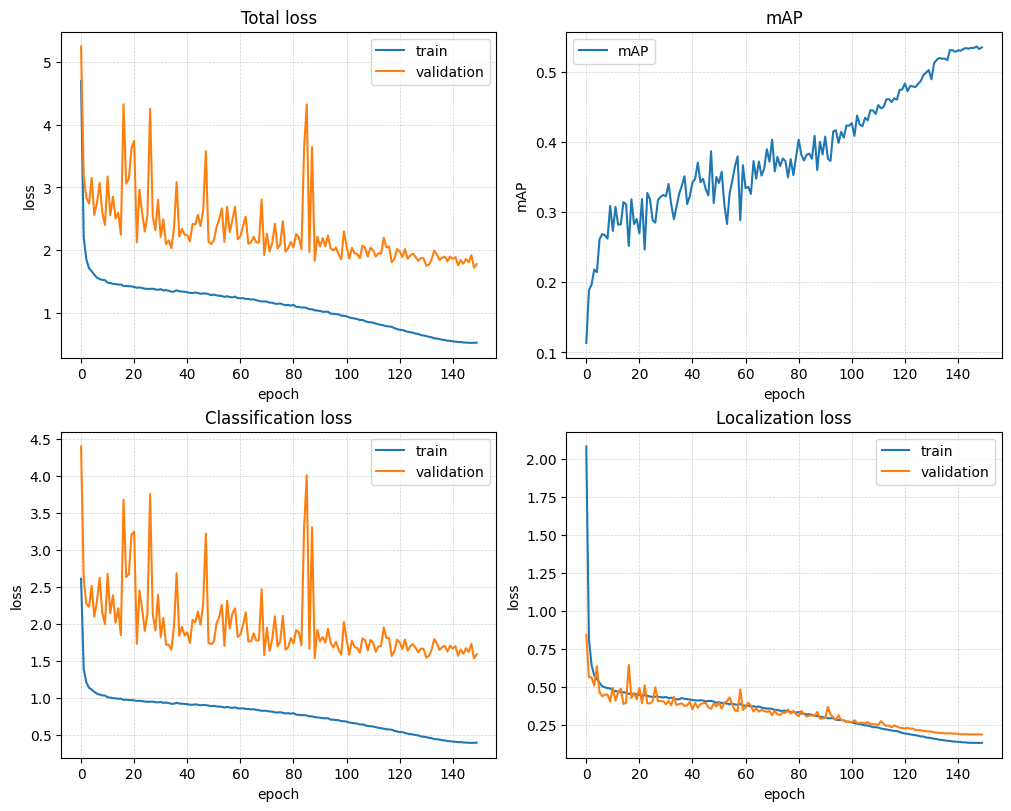

In [2]:
# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.RandomZoomOut(fill=0, p=0.5),       # Zoom out hurts model performance

    ConditionalIoUCrop(min_area_frac=0.02,   # threshold between "large" and "small"
                       small_min_scale=0.4,
                       large_min_scale=0.7,
                       max_scale=1.0,
                       min_aspect_ratio=0.75,
                       max_aspect_ratio=1.33,
                       small_sampler_options=(0.0, 0.05, 0.1, 2.0),
                       large_sampler_options=(0.05, 0.1, 0.3, 2.0),
                       trials=10),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# need to put dataloaders on cpu to use pin_memory
train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=1, rand_seed=724, include_area=False)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data_init, val_data = CarImageClass.make_train_test_split(full_set=train_set,
                                                                test_size=0.25,
                                                                rand_state=724,
                                                                transform_train=train_tfms,
                                                                transform_test=test_tfms,
                                                                include_area=False)

df = train_data_init.annotate_df

# 1) count non-empty objects per filename
obj_counts = (
    df.loc[df["class"] != "empty"]
      .groupby("filename")
      .size()                      # number of rows (objects) per filename
)

# 2) map counts back to all rows, defaulting to 0 when there are no objects
df["num_objects"] = (
    df["filename"]
      .map(obj_counts)            # NaN for filenames with only 'empty'
      .fillna(0)
      .astype(int)
)

filenames0 = df[df['num_objects'] == 0]['filename'].unique().tolist()
filenames12 = df[(df['num_objects'] >= 1) & (df['num_objects'] <= 2)]['filename'].unique().tolist()
filenames36 = df[(df['num_objects'] >= 3) & (df['num_objects'] <= 6)]['filename'].unique().tolist()
filenames79 = df[(df['num_objects'] >= 7) & (df['num_objects'] <= 9)]['filename'].unique().tolist()
filenames10p = df[df['num_objects'] >= 10]['filename'].unique().tolist()

biglist = filenames0 + filenames12 + filenames12 + filenames36 + filenames36 + filenames36 + filenames79 + filenames79 + filenames79 + filenames79 + filenames10p + filenames10p + filenames10p + filenames10p + filenames10p

train_data = CarImageClass.ImageClass(targ_dir=train_path, file_list=biglist, transform=train_tfms, file_pct=1, rand_seed=724, include_area=False)

ssdtestmodel = mySSD(class_to_idx_dict=train_data.class_to_idx, in_channels=3, variances=(0.1, 0.2)).to(device)

del filenames0, filenames12, filenames36, filenames79, filenames10p, biglist, df, train_set


if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)
    
BATCH_SIZE = 16
NUM_WORKERS = 8
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              prefetch_factor=2,
                              pin_memory=True,
                              collate_fn=collate_detection
                              )

val_dataloader = DataLoader(val_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            persistent_workers=True,
                            prefetch_factor=2,
                            pin_memory=True,
                            collate_fn=collate_detection
                            )

optimizer, scheduler = build_optimizer_and_scheduler(model=ssdtestmodel,
                                                     train_dataloader=train_dataloader,
                                                     max_epochs=150,
                                                     warmup_epochs=5,
                                                     base_lr=0.003,
                                                     min_lr=1e-6,
                                                     momentum=0.9,
                                                     weight_decay=0.005)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel, optimizer=optimizer, scheduler=scheduler,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel.to(device)
else:
    start_epoch, best_map, loss_dict = 0, None, None

results = SSD_train(model=ssdtestmodel,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    sched_step_w_opt=True,
                    iou_thresh=0.4,
                    neg_pos_ratio=3.0,
                    score_thresh=0.2,
                    nms_thresh=0.3,
                    max_detections_per_img=100,
                    epochs=30,
                    early_stopping_rounds=None,
                    device=device,
                    save_model=True,
                    epoch_save_interval=None,
                    SAVE_DIR=r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models",
                    timing=False,
                    past_train_dict=loss_dict,
                    )

plot_losses(results)

In [ ]:
# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),       # Zoom out hurts model performance

    ConditionalIoUCrop(min_area_frac=0.02,   # threshold between "large" and "small"
                       small_min_scale=0.4,
                       large_min_scale=0.7,
                       max_scale=1.0,
                       min_aspect_ratio=0.75,
                       max_aspect_ratio=1.33,
                       small_sampler_options=(0.0, 0.05, 0.1, 2.0),
                       large_sampler_options=(0.05, 0.1, 0.3, 2.0),
                       trials=10),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# need to put dataloaders on cpu to use pin_memory
train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=1, rand_seed=724, include_area=False)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data_init, val_data = CarImageClass.make_train_test_split(full_set=train_set,
                                                                test_size=0.25,
                                                                rand_state=724,
                                                                transform_train=train_tfms,
                                                                transform_test=test_tfms,
                                                                include_area=False)

ssdtestmodel = mySSD(class_to_idx_dict=train_data_init.class_to_idx, in_channels=3, variances=(0.1, 0.2)).to(device)

if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)
    
BATCH_SIZE = 16
NUM_WORKERS = 8
# Create DataLoader's
train_dataloader = DataLoader(train_data_init, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              prefetch_factor=2,
                              pin_memory=True,
                              collate_fn=collate_detection
                              )

val_dataloader = DataLoader(val_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            persistent_workers=True,
                            prefetch_factor=2,
                            pin_memory=True,
                            collate_fn=collate_detection
                            )

optimizer, scheduler = build_optimizer_and_scheduler(model=ssdtestmodel,
                                                     train_dataloader=train_dataloader,
                                                     max_epochs=150,
                                                     warmup_epochs=5,
                                                     base_lr=0.003,
                                                     min_lr=1e-6,
                                                     momentum=0.9,
                                                     weight_decay=0.005)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel, optimizer=optimizer, scheduler=scheduler,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel.to(device)
else:
    start_epoch, best_map, loss_dict = 0, None, None

results = SSD_train(model=ssdtestmodel,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    sched_step_w_opt=True,
                    iou_thresh=0.4,
                    neg_pos_ratio=3.0,
                    score_thresh=0.2,
                    nms_thresh=0.3,
                    max_detections_per_img=100,
                    epochs=150,
                    early_stopping_rounds=None,
                    device=device,
                    save_model=True,
                    epoch_save_interval=None,
                    SAVE_DIR=r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models",
                    timing=False,
                    past_train_dict=loss_dict,
                    )

plot_losses(results)

In [16]:
ckpt_path = r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\12_2_2025_ZoomOut.ckpt"
out_path  = r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\12_2_2025_ZoomOut_weight_only.pth"

# 1) Load the checkpoint as a raw dict
ckpt = torch.load(ckpt_path, map_location="cpu")

# 2) Inspect keys if you want
print(ckpt.keys())

# 3) Extract the model state_dict
state_dict = ckpt["model_state"]

# 4) Save a clean weights-only file
torch.save(state_dict, out_path)

print(f"Saved weights-only state_dict to {out_path}")


dict_keys(['epoch', 'model_state', 'optimizer_state', 'scheduler_state', 'scaler_state', 'best_metric', 'rng_state', 'loss_dict'])
Saved weights-only state_dict to C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\12_2_2025_ZoomOut_weight_only.pth


C:\Users\eblac\AppData\Local\Temp\ipykernel_17520\2305257824.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


In [ ]:
ssd_model = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                  in_channels=3,
                  variances=(0.1, 0.2))

ssd_model.to(device='cpu')

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\last_11_26_2025_mAP_467_noZoomOut_weight_only.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")
missing, unexpected = ssd_model.load_state_dict(state_dict, strict=False)
print("missing:", missing)
print("unexpected:", unexpected)

missing: []
unexpected: ['priors', 'priors_xyxy']


C:\Users\eblac\AppData\Local\Temp\ipykernel_17492\208277677.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")


C:\Users\eblac\AppData\Local\Temp\ipykernel_19260\1706398502.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


dict_keys(['epoch', 'model_state', 'optimizer_state', 'scheduler_state', 'scaler_state', 'best_metric', 'rng_state', 'loss_dict'])


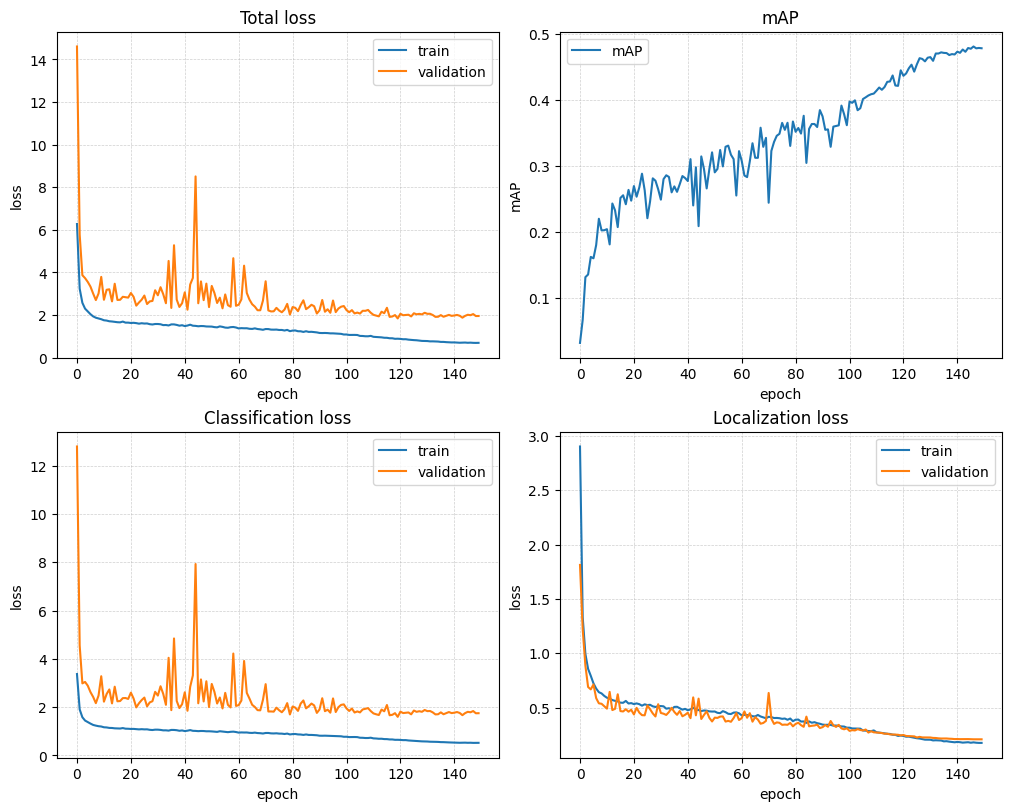

In [7]:
ckpt_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last_11_26_2025_mAP_467_noZoomOut.ckpt"

ckpt = torch.load(ckpt_path, map_location="cpu")
print(ckpt.keys())          # inspect what’s inside
loss_dict = ckpt["loss_dict"]  # or whatever key shows up
plot_losses(loss_dict)

C:\Users\eblac\AppData\Local\Temp\ipykernel_17520\2096584524.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location="cpu")


dict_keys(['epoch', 'model_state', 'optimizer_state', 'scheduler_state', 'scaler_state', 'best_metric', 'rng_state', 'loss_dict'])


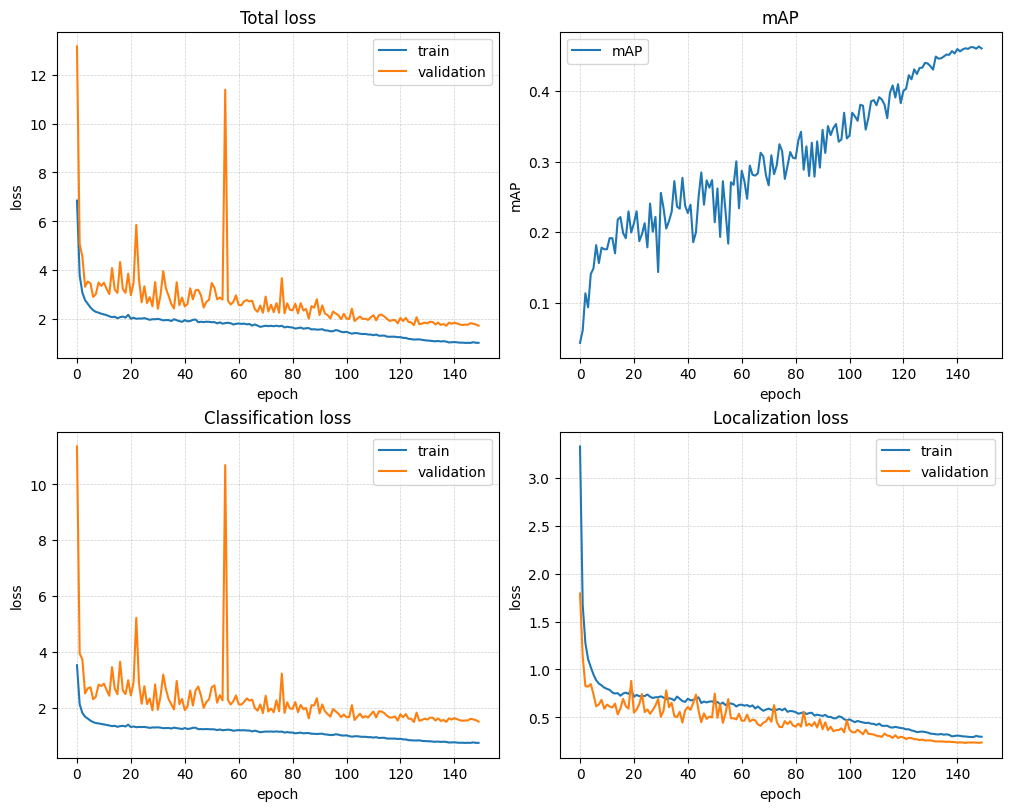

In [14]:
ckpt_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "12_2_2025_ZoomOut.ckpt"

ckpt = torch.load(ckpt_path, map_location="cpu")
print(ckpt.keys())          # inspect what’s inside
loss_dict = ckpt["loss_dict"]  # or whatever key shows up
plot_losses(loss_dict)

In [ ]:
ssdtestmodel = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                  in_channels=3,
                  variances=(0.1, 0.2)).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=3e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.2, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last_11_26_2025_mAP_467_noZoomOut.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel, optimizer=optimizer, scheduler=scheduler,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel.to(device)
else:
    start_epoch, best_map, loss_dict = 0, None, None

RuntimeError: Error(s) in loading state_dict for mySSD:
	Unexpected key(s) in state_dict: "priors", "priors_xyxy". 

In [3]:
print(scheduler.get_last_lr())

[0.0001875]


In [ ]:
def max_fitting_batch_size(model, sample_batch, loss_fn, device, lo=1, hi=128):
    x, y = sample_batch  # one batch from your DataLoader with collate_detection
    x = x.to(device, non_blocking=True)
    # y is a dict/list of dicts; move tensors inside as needed
    def to_dev(t):
        return t.to(device, non_blocking=True) if hasattr(t, "to") else t
    y = [{k: to_dev(v) for k, v in t.items()} for t in y]

    import torch, math
    model.train()
    best = 0
    while lo <= hi:
        mid = (lo + hi) // 2
        try:
            torch.cuda.empty_cache()
            x_rep = x[:1].repeat(mid, 1, 1, 1)  # synthetic replicate
            y_rep = y * mid
            for p in model.parameters():
                if p.grad is not None: p.grad = None
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                out = model(x_rep)
                loss = loss_fn(out, y_rep)
            loss.backward()
            best = mid
            lo = mid + 1
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                torch.cuda.empty_cache()
                hi = mid - 1
            else:
                raise
    return best


In [2]:
ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=1e-3, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),

    ConditionalIoUCrop(
        min_area_frac=0.02,
        min_scale=0.6, max_scale=1.0,
        min_aspect_ratio=0.75, max_aspect_ratio=1.33,
        sampler_options=[0.05, 0.1, 0.3],
        trials=3
    ),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=0.02)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set, test_size=0.25, transform_train=train_tfms, transform_test=test_tfms)

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 8

ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=3e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),

    ConditionalIoUCrop(
        min_area_frac=0.02,
        min_scale=0.6, max_scale=1.0,
        min_aspect_ratio=0.75, max_aspect_ratio=1.33,
        sampler_options=[0.05, 0.1, 0.3],
        trials=3
    ),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=0.01, device='cpu')

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              pin_memory=True,
                              persistent_workers=True,
                              prefetch_factor=1,
                              collate_fn=collate_detection
                              )

torch.cuda.synchronize()
t0 = time.time()
for batch, (images, targets) in enumerate(train_dataloader):
    torch.cuda.synchronize()
    t_load = time.time()
    images = images.to(device)
    
    # forward pass
    loc_all, conf_all = ssdtestmodel(images)
    N, P, C = conf_all.shape          # N - batch size, P - number of priors (8732), C - number of classes

    # -------- 1) Build per-image targets via encode() --------
    H, W = images.shape[-2], images.shape[-1]     # image size - should be 300x300
    norm = torch.tensor([W, H, W, H], device=device, dtype=torch.float32)

    loc_t_list   = []
    cls_t_list   = []
    pos_mask_lst = []

    for i in range(N):
        # normalize GT to [0,1] and convert to cxcywh
        gt_xyxy_px = targets[i]['boxes'].to(device=device, dtype=torch.float32)
        gt_labels  = targets[i]['labels'].to(device=device)
        if gt_xyxy_px.numel() == 0:
            gt_cxcywh = gt_xyxy_px.new_zeros((0,4))
        else:
            gt_xyxy = gt_xyxy_px / norm
            gt_cxcywh = box_convert(gt_xyxy, in_fmt='xyxy', out_fmt='cxcywh')

        loc_t, cls_t, pos_mask, _ = mySSD.encode_ssd(
            gt_cxcywh, gt_labels, ssdtestmodel.priors,
            iou_thresh=0.5, variances=(0.1, 0.2), background_class=0
        )
        # shapes: [P,4], [P], [P]
        loc_t_list.append(loc_t)
        cls_t_list.append(cls_t)
        pos_mask_lst.append(pos_mask)

    loc_t   = torch.stack(loc_t_list, dim=0).to(device)      # [N,P,4]
    cls_t   = torch.stack(cls_t_list, dim=0).to(device)      # [N,P]
    pos_mask = torch.stack(pos_mask_lst, dim=0).to(device)   # [N,P] bool
    neg_mask = ~pos_mask

    # number of positives per image (avoid zero division)
    num_pos_per_img = pos_mask.sum(dim=1)                    # [N]
    total_pos = num_pos_per_img.sum().clamp_min(1).float()   # scalar


    # -------- 2) Localization loss (positives only) --------
    # SmoothL1 on offsets (no decode), sum then normalize by #pos
    loc_loss_sL1 = torch.nn.functional.smooth_l1_loss(
        loc_all[pos_mask], loc_t[pos_mask], reduction='sum'
    ) / total_pos

    # -------- 3) Classification loss with hard-negative mining --------
    # cross-entropy per prior (no reduction)
    ce = torch.nn.functional.cross_entropy(
        conf_all.view(-1, C), cls_t.view(-1), reduction='none'
    ).view(N, P)  # [N,P]

    # keep CE on positives always
    ce_pos = (ce * pos_mask.float()).sum()

    # select hardest negatives per image at ratio R:1 w.r.t positives
    ce_neg_sum = torch.tensor(0.0, device=device)
    for i in range(N):
        n_pos = int(num_pos_per_img[i].item())
        if n_pos == 0:
            # still allow some negatives to contribute (common trick: pretend 1 positive)
            max_negs = int(3)
        else:
            max_negs = int(3 * n_pos)

        ce_neg_i = ce[i].masked_select(neg_mask[i])         # [#neg_i]
        if ce_neg_i.numel() == 0 or max_negs == 0:
            continue
        k = min(max_negs, ce_neg_i.numel())
        topk_vals, _ = torch.topk(ce_neg_i, k, largest=True, sorted=False)
        ce_neg_sum += topk_vals.sum()

    conf_loss = (ce_pos + ce_neg_sum) / total_pos

    # loss
    batch_loss = loc_loss_sL1 + conf_loss
    
    # loc_loss += loc_loss_sL1.item()
    # cls_loss += conf_loss.item()
    # train_loss += batch_loss.item()

    # Optimizer zero grad
    optimizer.zero_grad(set_to_none=True)

    # loss backward
    batch_loss.backward()

    # optimizer step
    optimizer.step()


    t_step = time.time()
    if batch<15:
        print(f"batch {batch}: load {t_load-t0:.3f}s, step {t_step-t_load:.3f}s")
        t0 = time.time()
    else:
        break

batch 0: load 54.642s, step 2.101s
batch 1: load 0.000s, step 0.498s
batch 2: load 0.001s, step 0.304s
batch 3: load 0.224s, step 0.340s
batch 4: load 0.226s, step 0.438s
batch 5: load 0.219s, step 0.396s
batch 6: load 0.218s, step 0.266s
batch 7: load 0.220s, step 0.276s
batch 8: load 0.221s, step 0.303s
batch 9: load 0.223s, step 0.337s
batch 10: load 0.214s, step 0.320s
batch 11: load 0.219s, step 0.270s
batch 12: load 0.220s, step 0.259s


In [8]:
ssdtestmodel_loaded = mySSD(class_to_idx_dict=val_data.class_to_idx, in_channels=3).to(device)
optimizer_loaded = torch.optim.SGD(ssdtestmodel_loaded.parameters(), lr=3e-3, momentum=0.9)
scheduler_loaded = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_loaded, mode='min', factor=0.5, patience=5, threshold=1e-3, cooldown=0, min_lr=1e-6)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel_loaded, optimizer=optimizer_loaded, scheduler=scheduler_loaded,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel_loaded.to(device)
else:
    start_epoch, best_map = 0, None

In [9]:
min_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.Resize((300, 300), antialias=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data_clean = CarImageClass.ImageClass(targ_dir=test_path, transform=min_tfms, file_pct=1)
test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002304B34B740>
Traceback (most recent call last):
  File "c:\Users\eblac\anaconda3\envs\torchGPUenv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\eblac\anaconda3\envs\torchGPUenv\Lib\site-packages\torch\utils\data\dataloader.py", line 1563, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "c:\Users\eblac\anaconda3\envs\torchGPUenv\Lib\site-packages\torch\utils\data\dataloader.py", line 1499, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


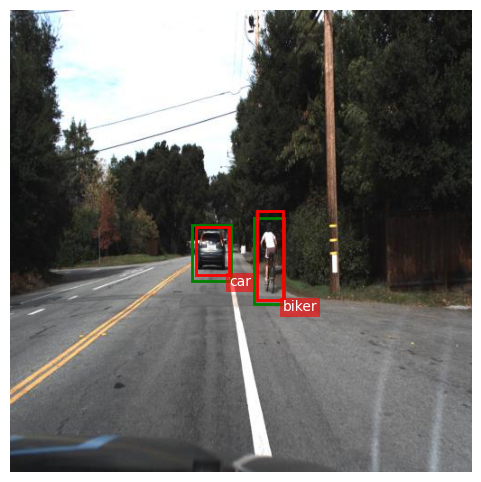

In [25]:
idx = np.random.randint(0, len(test_data))

testpred = ssdtestmodel_loaded.predict(images=test_data[idx][0].unsqueeze(dim=0).to(device),
                                       score_thresh=0.2,
                                       nms_thresh=0.3,
                                       max_per_img=100)

# pred_boxs = testpred[0]['boxes'].to('cpu')
# pred_labels = ids_to_names(testpred[0]['labels'].tolist() if type(testpred[0]['labels']) != list else testpred[0]['labels'], mapping=id2name)

test_data_clean.show_with_box(index=idx, color='g', lw=2, label=False, pred_dict=testpred[0], pred_color='r', lw_pred=2, pred_label=True);

In [26]:
path_list = list(Path(r"C:\Udacity_car_data\data\my test photos").glob("*.jpg"))

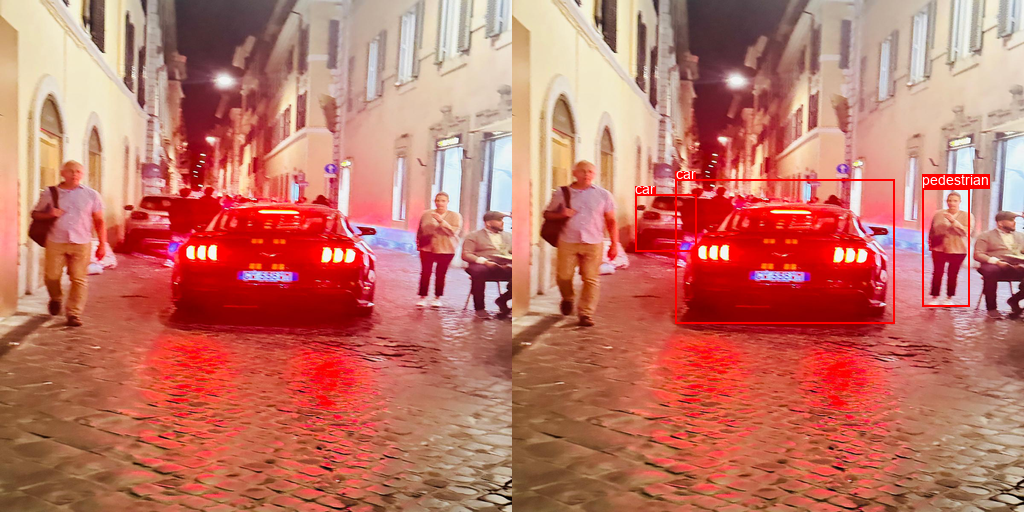

In [49]:
ssdtestmodel_loaded.show_prediction_side_by_side(image_path=path_list[17],
                                                 pil_img=None,
                                                 score_thresh=0.2,
                                                 nms_thresh=0.3,
                                                 max_per_img=200,
                                                 class_agnostic=False,
                                                 target_width=512,
                                                 target_height=512)

In [6]:
ssdtestmodel_loaded = mySSD(class_to_idx_dict=val_data.class_to_idx, in_channels=3).to(device)
optimizer_loaded = torch.optim.SGD(ssdtestmodel_loaded.parameters(), lr=3e-3, momentum=0.9)
scheduler_loaded = StepLR(optimizer_loaded, step_size=5, gamma=0.8)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "last.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel_loaded, optimizer=optimizer_loaded, scheduler=scheduler_loaded,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel_loaded.to(device)
else:
    start_epoch, best_map = 0, None


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric.reset()

for images, targets in test_dataloader:
    preds = ssdtestmodel_loaded.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)   # list[dict] per image
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)

mAP_test_results = map_metric.compute()

mAP_test_results

{'map': tensor(0.5292),
 'map_50': tensor(0.5292),
 'map_75': tensor(-1.),
 'map_small': tensor(0.4581),
 'map_medium': tensor(0.8496),
 'map_large': tensor(0.8414),
 'mar_1': tensor(0.2969),
 'mar_10': tensor(0.5768),
 'mar_100': tensor(0.5781),
 'mar_small': tensor(0.5185),
 'mar_medium': tensor(0.8617),
 'mar_large': tensor(0.8485),
 'map_per_class': tensor([0.4045, 0.7088, 0.2907, 0.5956, 0.6465]),
 'mar_100_per_class': tensor([0.4441, 0.7409, 0.3825, 0.6553, 0.6679]),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [19]:
ssd_model = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                  in_channels=3,
                  variances=(0.1, 0.2))

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\12_2_2025_ZoomOut_weight_only.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")
missing, unexpected = ssd_model.load_state_dict(state_dict, strict=False)
print("missing:", missing)
print("unexpected:", unexpected)

ssd_model.load_state_dict(state_dict, strict=False)
ssd_model.to(device=device)


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric.reset()

for images, targets in test_dataloader:
    preds = ssd_model.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)   # list[dict] per image
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)

mAP_test_results = map_metric.compute()

mAP_test_results

C:\Users\eblac\AppData\Local\Temp\ipykernel_17520\2937913737.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")


missing: []
unexpected: ['priors', 'priors_xyxy']


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000018360E560C0>
Traceback (most recent call last):
  File "c:\Users\eblac\anaconda3\envs\torchGPUenv\Lib\site-packages\torch\utils\data\dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "c:\Users\eblac\anaconda3\envs\torchGPUenv\Lib\site-packages\torch\utils\data\dataloader.py", line 1563, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "c:\Users\eblac\anaconda3\envs\torchGPUenv\Lib\site-packages\torch\utils\data\dataloader.py", line 1499, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


{'map': tensor(0.4613),
 'map_50': tensor(0.4613),
 'map_75': tensor(-1.),
 'map_small': tensor(0.3816),
 'map_medium': tensor(0.8154),
 'map_large': tensor(0.7936),
 'mar_1': tensor(0.2667),
 'mar_10': tensor(0.5169),
 'mar_100': tensor(0.5180),
 'mar_small': tensor(0.4461),
 'mar_medium': tensor(0.8495),
 'mar_large': tensor(0.7997),
 'map_per_class': tensor([0.2854, 0.6618, 0.2145, 0.5571, 0.5875]),
 'mar_100_per_class': tensor([0.3397, 0.7056, 0.3021, 0.6127, 0.6299]),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [21]:
ssd_model = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                  in_channels=3,
                  variances=(0.1, 0.2))

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\last_11_26_2025_mAP_467_noZoomOut_weight_only.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")
missing, unexpected = ssd_model.load_state_dict(state_dict, strict=False)
print("missing:", missing)
print("unexpected:", unexpected)

ssd_model.load_state_dict(state_dict, strict=False)
ssd_model.to(device=device)


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric.reset()

for images, targets in test_dataloader:
    preds = ssd_model.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)   # list[dict] per image
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)

mAP_test_results = map_metric.compute()

mAP_test_results

C:\Users\eblac\AppData\Local\Temp\ipykernel_17520\453607767.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(WEIGHTS_PATH, map_location="cpu")


missing: []
unexpected: ['priors', 'priors_xyxy']


{'map': tensor(0.4724),
 'map_50': tensor(0.4724),
 'map_75': tensor(-1.),
 'map_small': tensor(0.3901),
 'map_medium': tensor(0.8247),
 'map_large': tensor(0.9411),
 'mar_1': tensor(0.2719),
 'mar_10': tensor(0.5237),
 'mar_100': tensor(0.5248),
 'mar_small': tensor(0.4515),
 'mar_medium': tensor(0.8554),
 'mar_large': tensor(0.9485),
 'map_per_class': tensor([0.3015, 0.6681, 0.2314, 0.5619, 0.5992]),
 'mar_100_per_class': tensor([0.3587, 0.7053, 0.3225, 0.6125, 0.6247]),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [23]:
ssd_model_ZO_noBS = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                          in_channels=3,
                          variances=(0.1, 0.2))
ssd_model_noZO_noBS = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                            in_channels=3,
                            variances=(0.1, 0.2))
ssd_model_noZO_BS = mySSD(class_to_idx_dict={'biker': 0, 'car': 1, 'pedestrian': 2, 'trafficLight': 3, 'truck': 4},
                          in_channels=3,
                          variances=(0.1, 0.2))

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\12_2_2025_ZoomOut_weight_only.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu", weights_only=False)
ssd_model_ZO_noBS.load_state_dict(state_dict, strict=False)
ssd_model_ZO_noBS.to(device=device)

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\last_11_26_2025_mAP_467_noZoomOut_weight_only.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu", weights_only=False)
ssd_model_noZO_noBS.load_state_dict(state_dict, strict=False)
ssd_model_noZO_noBS.to(device=device)

WEIGHTS_PATH = r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\12_6_2025_mAP_529_weight_only.pth"
state_dict = torch.load(WEIGHTS_PATH, map_location="cpu", weights_only=False)
ssd_model_noZO_BS.load_state_dict(state_dict, strict=False)
ssd_model_noZO_BS.to(device=device)


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric_ZO_noBS = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric_noZO_noBS = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric_noZO_BS = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric_ZO_noBS.reset()
map_metric_noZO_noBS.reset()
map_metric_noZO_BS.reset()

for images, targets in test_dataloader:
    preds_ZO_noBS = ssd_model_ZO_noBS.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)     # list[dict] per image
    preds_noZO_noBS = ssd_model_noZO_noBS.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)
    preds_noZO_BS = ssd_model_noZO_BS.predict(images.to(device), score_thresh=0.2, nms_thresh=0.3, max_per_img=100)
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric_ZO_noBS.update(preds=preds_ZO_noBS, target=targets)
    map_metric_noZO_noBS.update(preds=preds_noZO_noBS, target=targets)
    map_metric_noZO_BS.update(preds=preds_noZO_BS, target=targets)

mAP_test_results_ZO_noBS = map_metric_ZO_noBS.compute()
mAP_test_results_noZO_noBS = map_metric_noZO_noBS.compute()
mAP_test_results_noZO_BS = map_metric_noZO_BS.compute()

print()
print(mAP_test_results_ZO_noBS)
print()
print(mAP_test_results_noZO_noBS)
print()
print(mAP_test_results_noZO_BS)


{'map': tensor(0.4613), 'map_50': tensor(0.4613), 'map_75': tensor(-1.), 'map_small': tensor(0.3816), 'map_medium': tensor(0.8154), 'map_large': tensor(0.7936), 'mar_1': tensor(0.2667), 'mar_10': tensor(0.5169), 'mar_100': tensor(0.5180), 'mar_small': tensor(0.4461), 'mar_medium': tensor(0.8495), 'mar_large': tensor(0.7997), 'map_per_class': tensor([0.2854, 0.6618, 0.2145, 0.5571, 0.5875]), 'mar_100_per_class': tensor([0.3397, 0.7056, 0.3021, 0.6127, 0.6299]), 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

{'map': tensor(0.4724), 'map_50': tensor(0.4724), 'map_75': tensor(-1.), 'map_small': tensor(0.3901), 'map_medium': tensor(0.8247), 'map_large': tensor(0.9411), 'mar_1': tensor(0.2719), 'mar_10': tensor(0.5237), 'mar_100': tensor(0.5248), 'mar_small': tensor(0.4515), 'mar_medium': tensor(0.8554), 'mar_large': tensor(0.9485), 'map_per_class': tensor([0.3015, 0.6681, 0.2314, 0.5619, 0.5992]), 'mar_100_per_class': tensor([0.3587, 0.7053, 0.3225, 0.6125, 0.6247]), 'classes': te

In [11]:
def plot_lr_vs_batch(
    optimizer: torch.optim.Optimizer,
    scheduler,
    num_epochs: int,
    steps_per_epoch: int,
) -> None:
    """
    Plot learning rate vs global batch index, with epoch boundaries annotated.

    Assumptions:
      - scheduler.step() is called ONCE PER BATCH
      - optimizer.param_groups[0]["lr"] is the LR you care about
    """
    lrs = []
    steps = []

    global_step = 0
    for epoch in range(num_epochs):
        for step_in_epoch in range(steps_per_epoch):
            # record current LR before stepping
            current_lr = optimizer.param_groups[0]["lr"]
            lrs.append(current_lr)
            steps.append(global_step)

            # advance scheduler one batch
            scheduler.step()
            global_step += 1

    fig, ax = plt.subplots()
    ax.plot(steps, lrs)
    ax.set_xlabel("global batch (step)")
    ax.set_ylabel("learning rate")

    # epoch boundaries every 5 epochs in terms of global steps
    tick_epochs = list(range(0, num_epochs + 1, 5))  # 0, 5, 10, ...
    epoch_boundaries = [e * steps_per_epoch for e in tick_epochs]
    ax.set_xticks(epoch_boundaries)
    ax.set_xticklabels([str(e) for e in tick_epochs])
    plt.xticks(rotation=90)

    ax.set_title("Learning rate vs. batch (ticks = epoch indices)")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    fig.tight_layout()


In [12]:
# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    # v2.RandomZoomOut(fill=0, p=0.5),       # Zoom out likey hurts model performance

    ConditionalIoUCrop(min_area_frac=0.02,   # 1% threshold between "large" and "small"
                       small_min_scale=0.4,
                       large_min_scale=0.7,
                       max_scale=1.0,
                       min_aspect_ratio=0.75,
                       max_aspect_ratio=1.33,
                       small_sampler_options=(0.0, 0.05, 0.1, 2.0),
                       large_sampler_options=(0.05, 0.1, 0.3, 2.0),
                       trials=10),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

# need to put dataloaders on cpu to use pin_memory
train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=1, rand_seed=724, include_area=False)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set,
                                                           test_size=0.25,
                                                           rand_state=724,
                                                           transform_train=train_tfms,
                                                           transform_test=test_tfms,
                                                           include_area=False)

ssdmodel = mySSD(class_to_idx_dict=train_data.class_to_idx, in_channels=3, variances=(0.1, 0.2)).to(device)

if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)
    
BATCH_SIZE = 16
NUM_WORKERS = 8
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              prefetch_factor=2,
                              pin_memory=True,
                              collate_fn=collate_detection
                              )

val_dataloader = DataLoader(val_data, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            num_workers=NUM_WORKERS,
                            persistent_workers=True,
                            prefetch_factor=2,
                            pin_memory=True,
                            collate_fn=collate_detection
                            )

optimizer, scheduler = build_optimizer_and_scheduler(model=ssdmodel,
                                                     train_dataloader=train_dataloader,
                                                     max_epochs=150,
                                                     warmup_epochs=5,
                                                     base_lr=0.003,
                                                     min_lr=1e-6,
                                                     momentum=0.9,
                                                     weight_decay=0.005)

c:\Users\eblac\anaconda3\envs\torchGPUenv\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


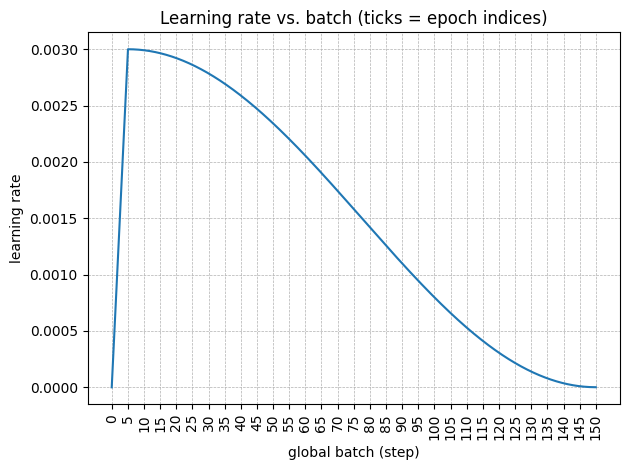

In [13]:
plot_lr_vs_batch(optimizer=optimizer,
                 scheduler=scheduler,
                 num_epochs=150,
                 steps_per_epoch=len(train_dataloader),)

In [39]:
ssdtestmodel_loaded = mySSD(num_classes=6).to(device)
optimizer_loaded = torch.optim.SGD(ssdtestmodel_loaded.parameters(), lr=3e-3, momentum=0.9)
scheduler_loaded = StepLR(optimizer_loaded, step_size=5, gamma=0.8)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "best.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel_loaded, optimizer=optimizer_loaded, scheduler=scheduler_loaded,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel_loaded.to(device)
else:
    start_epoch, best_map = 0, None


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1, device=device)

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                             num_workers=8,
                             persistent_workers=True,
                             prefetch_factor=2,
                             pin_memory=False,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric.reset()

for images, targets in test_dataloader:
    preds = ssdtestmodel_loaded.predict(images.to(device), score_thresh=0.2, max_per_img=100)   # list[dict] per image
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)

mAP_test_results = map_metric.compute()

mAP_test_results

{'map': tensor(0.4119),
 'map_50': tensor(0.4119),
 'map_75': tensor(-1.),
 'map_small': tensor(0.3468),
 'map_medium': tensor(0.6039),
 'map_large': tensor(0.7688),
 'mar_1': tensor(0.2420),
 'mar_10': tensor(0.4738),
 'mar_100': tensor(0.4749),
 'mar_small': tensor(0.4157),
 'mar_medium': tensor(0.6701),
 'mar_large': tensor(0.7777),
 'map_per_class': tensor([0.2660, 0.6098, 0.1797, 0.4852, 0.5187]),
 'mar_100_per_class': tensor([0.3239, 0.6674, 0.2609, 0.5640, 0.5585]),
 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}

In [ ]:
ssdtestmodel_loaded = mySSD(num_classes=6).to(device)
optimizer_loaded = torch.optim.SGD(ssdtestmodel_loaded.parameters(), lr=1e-3, momentum=0.9)
scheduler_loaded = StepLR(optimizer_loaded, step_size=5, gamma=0.8)

resume_path = Path(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models") / "L1Loss_no_mAP_11_7_2025.ckpt"
if resume_path.exists():
    start_epoch, best_map, loss_dict = load_checkpoint(
        resume_path, ssdtestmodel_loaded, optimizer=optimizer_loaded, scheduler=scheduler_loaded,
        scaler=None, map_location="cpu"  # safe load, then move to device
    )
    ssdtestmodel_loaded.to(device)
else:
    start_epoch, best_map = 0, None


test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1, device='cpu')

test_dataloader = DataLoader(test_data, 
                             batch_size=16, 
                             shuffle=False, 
                            #  num_workers=NUM_WORKERS,
                            #  persistent_workers=True,
                            #  prefetch_factor=1,
                            #  pin_memory=True,
                             collate_fn=collate_detection
                             )

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox', iou_thresholds=[0.50], class_metrics=True).to(device)
map_metric.reset()

pred_time = 0
metric_update_time = 0
batch_counter = 0

for images, targets in test_dataloader:
    t0 = time.perf_counter()
    preds = ssdtestmodel_loaded.predict(images.to(device), score_thresh=0.2, max_per_img=100)   # list[dict] per image
    t1 = time.perf_counter()
    pred_time += t1 - t0
    # ensure preds/targets tensors are on `device` and labels are 0..C-1
    for i in range(len(targets)):
        for key in targets[i].keys():
            targets[i][key] = targets[i][key].to(device)
    #         # if (key == 'labels') & (len(targets[i][key]) != 0):     # the only time len(targets[i][key]) will be 0 is when background is present
    #         #     targets[i][key] = targets[i][key] - 1 # shift from 1, ..., C to 0, ..., C-1
    
    # for i in range(len(preds)):
    #     if len(preds[i]['labels']) != 0:
    #         preds[i]['labels'] = preds[i]['labels'] - 1   # shift from 1, ..., C to 0, ..., C-1
    
    map_metric.update(preds=preds, target=targets)
    t2 = time.perf_counter()
    metric_update_time += t2 - t1

    batch_counter += 1

t3 = time.perf_counter()
results = map_metric.compute()
t4 = time.perf_counter()
print(f"Metric computation time: {t4 - t3:.6f} s")

print(f"Average prediction time: {pred_time/batch_counter:.6f}")

print(f"Average update time: {metric_update_time/batch_counter:.6f}")

print(results)

Metric computation time: 2.019606 s
Average prediction time: 0.185348
Average update time: 0.005478
{'map': tensor(0.1652), 'map_50': tensor(0.1652), 'map_75': tensor(-1.), 'map_small': tensor(0.0745), 'map_medium': tensor(0.5174), 'map_large': tensor(0.8546), 'mar_1': tensor(0.1157), 'mar_10': tensor(0.1950), 'mar_100': tensor(0.1952), 'mar_small': tensor(0.1059), 'mar_medium': tensor(0.5669), 'mar_large': tensor(0.8679), 'map_per_class': tensor([0.0390, 0.3182, 0.0484, 0.1359, 0.2847]), 'mar_100_per_class': tensor([0.0505, 0.3643, 0.0773, 0.1665, 0.3173]), 'classes': tensor([0, 1, 2, 3, 4], dtype=torch.int32)}


In [6]:
results['map_50']

tensor(0.1652)

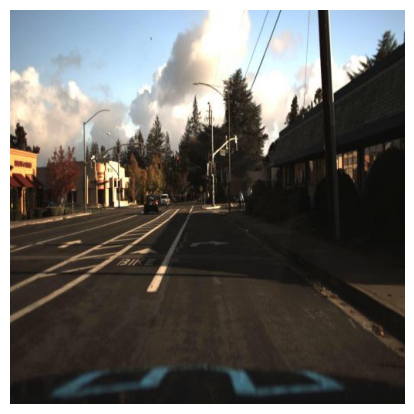

In [ ]:
# transforms
train_tfms = v2.Compose([
    #v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    #v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    #v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300)),                        # pick a fixed size for batching
    #v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=None, file_pct=1)

train_data.show_with_box(index=53, color='r', label=False, lw=0)

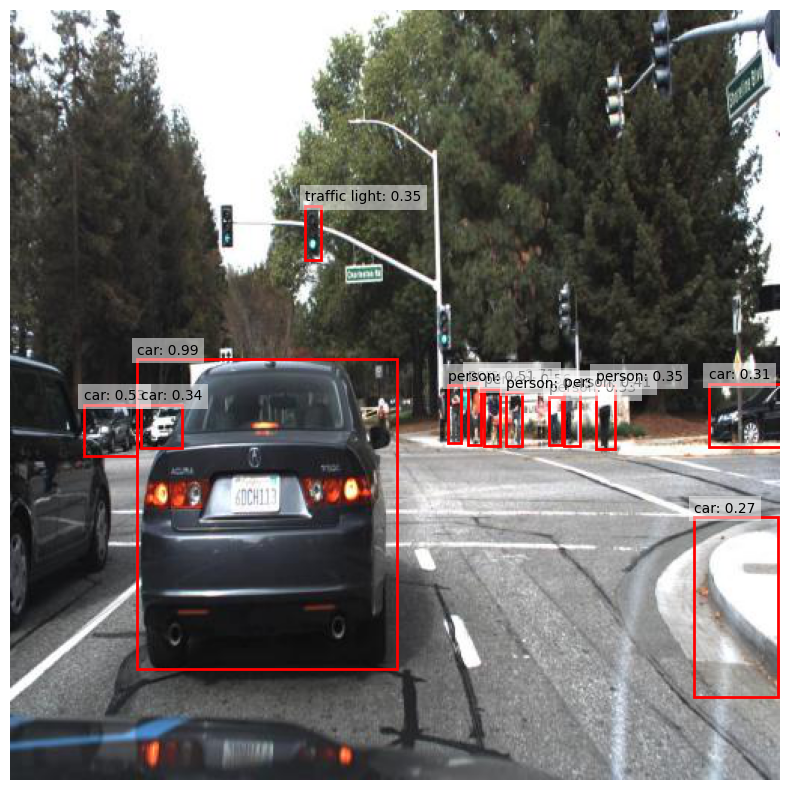

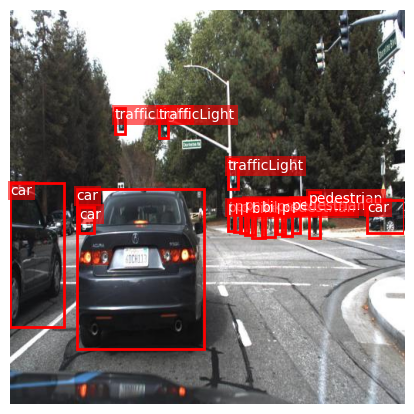

In [40]:
# 1) Device and weights
# device = torch.device("cpu")   # or "cuda" if available
weights = SSD300_VGG16_Weights.DEFAULT
categories = weights.meta["categories"]  # list of class names

# 2) Model
model = ssd300_vgg16(weights=weights).to(device).eval()

# 3) Load image
rand_idx = np.random.randint(0, len(test_data), size=1)[0]
img = test_data.load_image(rand_idx)
# img_path = np.random.choice(all_paths, size=1)[0] # r"C:\self-driving-car\data\train_one_obj\1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg" #"your_image.jpg"
# img = Image.open(img_path).convert("RGB")          # keep original for plotting

# 4) Preprocess
preprocess = weights.transforms()
img_t = preprocess(img)                            # Tensor [C, 300, 300]
batch = img_t.unsqueeze(0).to(device)              # [1, C, H, W]

# 5) Inference
with torch.no_grad():
    out = model(batch)[0]                          # dict with 'boxes','labels','scores'

# 6) Pull results to CPU numpy
boxes  = out["boxes"].cpu().numpy()                # shape [N,4], xyxy in *resized* coords
labels = out["labels"].cpu().numpy()               # shape [N]
scores = out["scores"].cpu().numpy()               # shape [N]

# 7) Confidence filtering
thr = 0.25
keep = scores >= thr
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
names = [categories[i] for i in labels]

# 8) (Optional) Map boxes back to original image size
H_resized, W_resized = img_t.shape[1], img_t.shape[2]  # 300, 300
H_orig,    W_orig    = 512, 512 #img.height, img.width
sx = W_orig / W_resized
sy = H_orig / H_resized
boxes_orig = boxes.copy()
boxes_orig[:, [0,2]] *= sx
boxes_orig[:, [1,3]] *= sy

# 9) (Optional) Visualize
def draw(img_pil, boxes_xyxy, labels_txt, scores_arr):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_pil)
    for (x1, y1, x2, y2), lbl, sc in zip(boxes_xyxy, labels_txt, scores_arr):
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, linewidth=2, edgecolor='r'))
        ax.text(x1, y1-3, f"{lbl}: {sc:.2f}", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
    ax.axis("off")
    plt.show()

draw(img, boxes_orig, names, scores)

test_data_clean.show_with_box(index=rand_idx, color='r', label=True)

In [165]:
# load model + COCO category names (order matches the model head)
weights = SSD300_VGG16_Weights.COCO_V1
categories = weights.meta["categories"]                      # list[str], length N
N = len(categories)

# rename rules and your final ids
rename = {"bicycle": "biker", "person": "pedestrian", "traffic light": "trafficLight"}
final_order = ["biker", "car", "pedestrian", "trafficLight", "truck"]
final_id = {n: i for i, n in enumerate(final_order)}

allowed_src = {"person", "bicycle", "car", "truck", "traffic light"}

model = ssd300_vgg16(weights=weights).eval().to(device)
preprocess = weights.transforms()

@torch.no_grad()
def predict_subset(imgs, score_thresh=0.05, topk=200, return_names=True):
    """
    Returns per-image dicts with:
      boxes:  float32 (N,4) xyxy
      scores: float32 (N,)
      labels: int64 in {0..4} using your mapping
      names:  renamed strings if return_names=True
    """
    outs = model(imgs)
    results = []

    for det in outs:
        boxes  = det["boxes"]
        scores = det["scores"]
        labels = det["labels"]  # DO NOT assume base

        # threshold
        keep = scores >= score_thresh
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        if labels.numel() == 0:
            results.append({
                "boxes":  boxes.to(torch.float32),
                "scores": scores.to(torch.float32),
                "labels": labels.new_zeros((0,), dtype=torch.int64),
                **({"names": []} if return_names else {})
            })
            continue

        # --- Detect label base (0-based vs 1-based) safely ---
        lmin, lmax = int(labels.min()), int(labels.max())
        if lmin < 0:
            raise ValueError(f"Negative label id {lmin} is invalid.")
        is_zero_based = (lmin == 0)
        if is_zero_based and lmax >= N:
            raise ValueError(f"Label max {lmax} out of range for {N} categories.")
        if (not is_zero_based) and (lmax > N):
            raise ValueError(f"1-based label max {lmax} out of range for {N} categories.")

        # map labels -> source names without off-by-one
        if is_zero_based:
            src_names = [categories[int(l)]     for l in labels]
        else:
            src_names = [categories[int(l) - 1] for l in labels]

        # keep only allowed classes by NAME (no id assumptions)
        keep_allowed = torch.tensor([n in allowed_src for n in src_names],
                                    device=labels.device, dtype=torch.bool)
        boxes, scores = boxes[keep_allowed], scores[keep_allowed]
        src_names = [n for n, m in zip(src_names, keep_allowed.tolist()) if m]

        if len(src_names) == 0:
            results.append({
                "boxes":  boxes.to(torch.float32),
                "scores": scores.to(torch.float32),
                "labels": torch.empty(0, device=labels.device, dtype=torch.int64),
                **({"names": []} if return_names else {})
            })
            continue

        # rename and map to your final contiguous ids
        renamed = [rename.get(n, n) for n in src_names]
        try:
            mapped_ids = torch.tensor([final_id[n] for n in renamed],
                                      device=labels.device, dtype=torch.int64)
        except KeyError as e:
            raise KeyError(f"Unexpected class after rename: {e.args[0]}") from e

        # top-k after filtering
        if scores.numel() > topk:
            idx = torch.topk(scores, topk).indices
            boxes  = boxes[idx]
            scores = scores[idx]
            mapped_ids = mapped_ids[idx]
            if return_names:
                renamed = [renamed[int(i)] for i in idx]

        out = {
            "boxes":  boxes.to(torch.float32),
            "scores": scores.to(torch.float32),
            "labels": mapped_ids,               # 0..4 exactly as requested
        }
        if return_names:
            out["names"] = renamed
        results.append(out)

    return results

In [ ]:
preprocess = weights.transforms()
imgs = [preprocess(your_image_tensor.to(device))]  # list of images

preds = predict_subset(imgs, score_thresh=0.25, return_names=True, remap_subset=True)

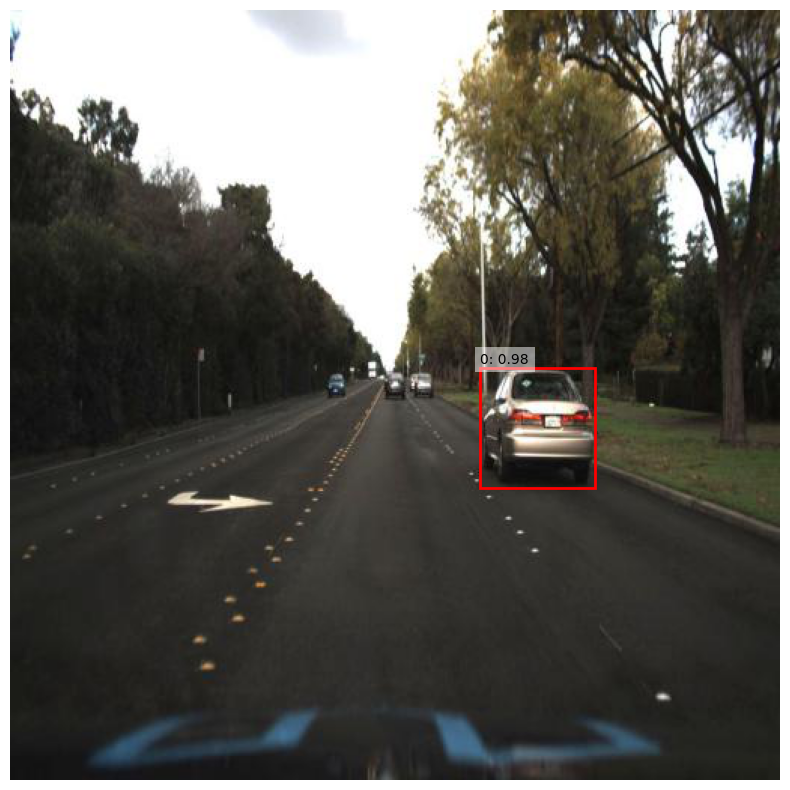

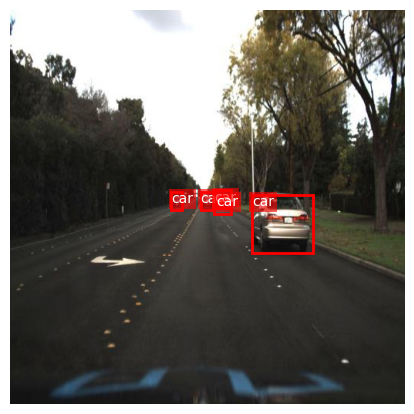

In [167]:
# 3) Load image
rand_idx = np.random.randint(0, len(test_data), size=1)[0]
img = test_data.load_image(rand_idx)
# img_path = np.random.choice(all_paths, size=1)[0] # r"C:\self-driving-car\data\train_one_obj\1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg" #"your_image.jpg"
# img = Image.open(img_path).convert("RGB")          # keep original for plotting

# 4) Preprocess
preprocess = weights.transforms()
img_t = preprocess(img)                            # Tensor [C, 300, 300]
batch = img_t.unsqueeze(0).to(device)              # [1, C, H, W]

# 5) Inference
with torch.no_grad():
    out = predict_subset(batch, score_thresh=0.25, return_names=True)[0] # list of dict with 'boxes','labels','scores'

# 6) Pull results to CPU numpy
boxes  = out["boxes"].cpu().numpy()                # shape [N,4], xyxy in *resized* coords
labels = out["labels"].cpu().numpy()               # shape [N]
scores = out["scores"].cpu().numpy()               # shape [N]

# 7) Confidence filtering
thr = 0.25
keep = scores >= thr
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
newcategories = ["biker", "car", "pedestrian", "trafficLight", "truck"]
names = labels


# 8) (Optional) Map boxes back to original image size
H_resized, W_resized = img_t.shape[1], img_t.shape[2]  # 300, 300
H_orig,    W_orig    = 512, 512 #img.height, img.width
sx = W_orig / W_resized
sy = H_orig / H_resized
boxes_orig = boxes.copy()
boxes_orig[:, [0,2]] *= sx
boxes_orig[:, [1,3]] *= sy

# 9) (Optional) Visualize
def draw(img_pil, boxes_xyxy, labels_txt, scores_arr):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_pil)
    for (x1, y1, x2, y2), lbl, sc in zip(boxes_xyxy, labels_txt, scores_arr):
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, linewidth=2, edgecolor='r'))
        ax.text(x1, y1-3, f"{lbl}: {sc:.2f}", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
    ax.axis("off")
    plt.show()

draw(img, boxes_orig, names, scores)

test_data_clean.show_with_box(index=rand_idx, color='r', label=True)

In [168]:
out

{'boxes': tensor([[312.2518, 237.7174, 388.7055, 317.5104]], device='cuda:0'),
 'scores': tensor([0.9797], device='cuda:0'),
 'labels': tensor([0], device='cuda:0'),
 'names': ['biker']}

In [64]:
test_data_clean[rand_idx][1]

{'image_id': tensor([4493]),
 'labels': tensor([1, 3, 3, 1, 3]),
 'boxes': BoundingBoxes([[ 17., 228., 215., 444.],
                [109., 119., 121., 159.],
                [173., 105., 185., 148.],
                [192., 230., 251., 304.],
                [276., 180., 286., 212.]], format=BoundingBoxFormat.XYXY, canvas_size=(512, 512)),
 'areas': tensor([42768.,   480.,   516.,  4366.,   320.]),
 'iscrowd': tensor([0, 0, 0, 0, 0])}